# Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

In [3]:
duration = data[duration_col].to_numpy().squeeze()
event = data[event_col].to_numpy().squeeze()

In [4]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [5]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X = feature_scaling(X)

In [6]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize clients 

In [77]:
N_SPLITS = 3
DATA_SPLIT_IDX = [np.arange(data.shape[0])] * N_SPLITS  #np.array_split(np.arange(data.shape[0]), N_SPLITS)

In [78]:
from utils.client import Client 

participants = [] 

rho = 1

for idx in DATA_SPLIT_IDX:
    # Init client objects with mutually exclusive data samples 
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    # Apply data pre-processing steps 
    client.preprocess_data(train_test_split=False)
    # Initialize model and parameters 
    client.init_model(local_knots=False, knots=knots, learning_rate=0.001)

    participants.append(client)

# Initialize parameters

In [79]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration)

# Initialize beta coefficients
beta = init_beta(X, y)

In [80]:
for client in participants:
    client.set_params({"beta": beta, "gamma": gamma})

# Fit clients 

In [81]:
# Global variables 
beta_global = np.zeros_like(client.beta)
gamma_global = np.zeros_like(client.gamma)

In [82]:
EPS = 1e-4
N_ITER_GLOBAL = 15000

Iter 0: 0.25542135953236633; 3.8735054734475223
Iter 1500: 0.0026457227042128604; 0.0026456947228891085
Iter 3000: 0.002645714256023638; 0.0026454920091524043
Iter 4500: 0.0026454441461384423; 0.0026427974488537303
Iter 6000: 0.0026455694103996886; 0.0026447487178944333
Iter 7500: 0.0026456031993159837; 0.002645064008553704
Iter 9000: 0.002645603198707494; 0.0026451541054186875
Iter 10500: 0.0026456088305922185; 0.002645064008553704
Iter 12000: 0.0026456116465615586; 0.002645244199214977
Iter 13500: 0.0026456172785122296; 0.002645244199214977


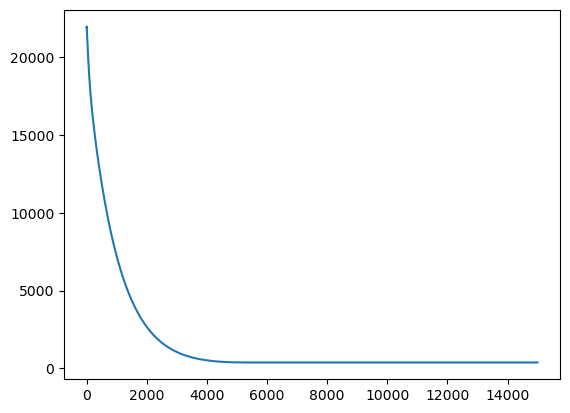

In [83]:
def has_converged(params, params_other):
    return np.linalg.norm(params_other - params) <= EPS 


def cosine_annealing_lr(epoch, max_epochs, initial_lr=0.1, min_lr=0.001):
    """
    Cosine annealing learning rate scheduler.
    """
    cos_inner = np.pi * epoch / max_epochs
    lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(cos_inner))
    return lr


losses = []

for i in range(N_ITER_GLOBAL):

    delta_beta, delta_gamma, last_local_losses = [], [], []
    
    for c, client in enumerate(participants):

        # Previous delta estimate 
        delta_beta_prev = client.beta + (client.u_beta / rho)
        delta_gamma_prev = client.gamma + (client.u_gamma / rho)

        # Update model params 
        client.fit_model_fedadmm(beta_global, gamma_global)

        # Update duals 
        client.update_duals(beta_global, gamma_global)

        # Next delta estimate 
        delta_beta_next = client.beta + (client.u_beta / rho)
        delta_gamma_next = client.gamma + (client.u_gamma / rho)

        delta_beta.append(delta_beta_next - delta_beta_prev)
        delta_gamma.append(delta_gamma_next - delta_gamma_prev)

        # Trace training loss 
        last_local_losses.append(client.loss)

    losses.append(np.mean(last_local_losses))

    # Update previous parameter estimate 
    beta_global_prev = beta_global.copy()
    gamma_global_prev = gamma_global.copy()

    # Global update
    lrate = 0.5 #cosine_annealing_lr(i, N_ITER_GLOBAL)    
    beta_global += lrate * np.mean(delta_beta, axis=0)
    gamma_global += lrate * np.mean(delta_gamma, axis=0)
    
    if has_converged(beta_global, beta_global_prev) and has_converged(gamma_global, gamma_global_prev):
        print(f"Converged after {i} iterations")
        break 

    if i % (N_ITER_GLOBAL / 10) == 0:
        change_beta = np.linalg.norm(beta_global - beta_global_prev) 
        change_gamma = np.linalg.norm(gamma_global - gamma_global_prev)
        print(f"Iter {i}: {change_beta}; {change_gamma}")


plt.figure()
plt.plot(losses)
# PROBLEM: The difference between consecutive parameter estimates seem to be converging. 
# This could mean that consecutive estimates alternative between similar solutions. 

In [61]:
# Save loss data to disk 
np.save("../data/losses/rossi_admm.npy", losses)

# Fit reference model 

Converged after 4426 iterations


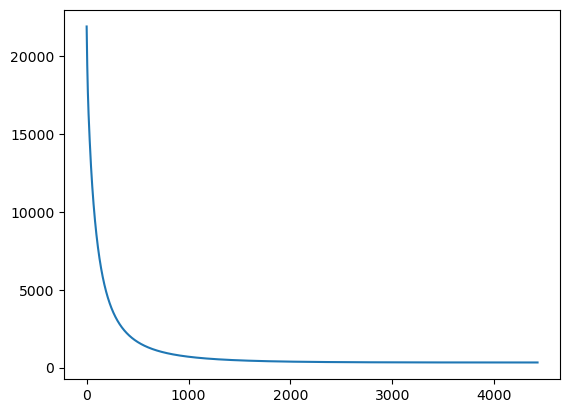

In [15]:
from utils.model import Model

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.01, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [16]:
ref_model.beta

array([[-0.17536245, -0.30535272,  0.09445201, -0.07586177, -0.12871987,
        -0.03621313,  0.24828063]], dtype=float32)

In [84]:
np.save("../data/params/rossi_admm_beta_global.npy", beta_global)
beta_global

array([[-0.1753625 , -0.31563169,  0.09304662, -0.0786709 , -0.1317191 ,
        -0.03726067,  0.24566056]])

In [18]:
np.linalg.norm(ref_model.beta - beta_global)

0.42938035542176545

In [19]:
ref_model.gamma

array([[-6.2007933, -4.9384947, -3.8407304, -2.0178106, -1.6342392,
        -1.3359975, -1.1990117]], dtype=float32)

In [85]:
np.save("../data/params/rossi_admm_gamma_global.npy", gamma_global)
gamma_global

array([[-4.21137047, -3.7048173 , -3.62750816, -2.01786518, -1.68083441,
        -1.39058375, -1.25523043]])

In [21]:
np.linalg.norm(ref_model.gamma - gamma_global)

9.08414698765255